In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Twitter Developer Account
In order to use Twitter’s API, we have to create a developer account on the Twitter apps site.
 * Log in or make a Twitter account at https://apps.twitter.com/.
 * Create a new app (button on the top right)
 
<img src=https://miro.medium.com/max/1400/0*Dq78m3JKoSqZY5SS.png style="width: 200px;">

Fill in the app creation page with a unique name, a website name (use a placeholder website if you don’t have one), and a project description. Accept the terms and conditions and proceed to the next page.

Once your project has been created, click on the “Keys and Access Tokens” tab. You should now be able to see your consumer secret and consumer key.

<img src=https://miro.medium.com/max/1400/0*YU1pFqTw6Dn-ZmOd.png style="width: 200px;">

You’ll also need a pair of access tokens. Scroll down and request those tokens. The page should refresh, and you should now have an access token and access token secret.

<img src=https://miro.medium.com/max/1400/0*_gnOgA0aaAqPgDJG.png style="width: 200px;">


## Import necessary modules

In [81]:
import sys
import os
import json
import re
import string
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [3]:
#Import the necessary methods from tweepy library  

#install tweepy if you don't have it
#!pip install tweepy
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#sentiment analysis package
#!pip install textblob
from textblob import TextBlob

#general text pre-processor
#!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

#tweet pre-processor 
#!pip install tweet-preprocessor
import preprocessor as ppr

[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


### Starting code
Below we define some starting codes (python classes and function) to illustrate and assist on how to fetch data from twitter and analyse them. 

### **Your task is**
1. Go through the code and understand it. Know what each function does
2. If you find error, fix it. Ask for help in the slack channel if you find serious mistake
3. Extend the code such that it will be useful for topics you choose to analyse
4. Make nice plots and share your finding (e.g.  insight on the main covid19 twitter converstions about your country)
5. Submit what ever you managed to do by Wednesday morning. But you should keep using what you build to write blogs, share on facebook, etc. 


[Reference used to build some of the functions here](https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf)

In [4]:
class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis.
        
    '''
    def __init__(self,cols=None,auth=None):
        #
        if cols is not None:  # for simplicity and easy comprehension by readers
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author',   
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
          
        if auth is None:
            #Variables that contains the user credentials to access Twitter API 
            consumer_key = os.environ.get('TWITTER_API_KEY')
            consumer_secret = os.environ.get('TWITTER_API_SECRET')
            access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
            access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')



            #This handles Twitter authetification and the connection to Twitter 
            #Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
            

        #            
        self.auth = auth
        self.api = tweepy.API(auth)     
        
            

    def clean_tweets(self,twitter_text):

        #use pre processor
        tweet = ppr.clean(twitter_text) # changed the object ###

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        #combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet) 
    
    
    def get_user(self, csv, hname):
        
        """
            this would get all user information for proper scoring.
            Information i would get here include favourite count and 
            statutes count, friends count and followers count
            
        """
        lnfl_list = []
        df = pd.read_csv(csv)
        handle = df[hname].to_list()
        for h in handle:
            try:
                user = self.api.get_user(id=h)
                json_str = json.dumps(user._json)
                lnfl_list.append(json.loads(json_str))
            except tweepy.error.TweepError:
                print('user handle not found')
                continue
        df1 = json_normalize(lnfl_list) 
        df1.to_csv(csvfile)
        
        return df1
    
    

    def get_tweets(self, handle ,  csvfile=None):
        
        
        df = pd.DataFrame(columns=self.cols) # commented out the line since data has been provided
        
        if not csvfile is None:
            #If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header = 0)   # changed to pd.read_json from read_csv since the data provided
                                                           # was a json file
                                                           # the dataframe was returned containing the data (tweet data)                     
            
        
        #page attribute in tweepy.cursor and iteration
        
        """
         this fetches users timeline to extract hashtags and mentions by the user
         
        """
        
        for page in tweepy.Cursor(self.api.user_timeline, id = handle ,count=20, include_rts=False).pages(10):


            for status in page:
                
                new_entry = []
                status = status._json
                
                #filter by language
                if status['lang'] != 'en':
                    continue

            
                #if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    #
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue

                #calculate sentiment
                filtered_tweet = self.clean_tweets(status['text'])
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment     
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['text'],filtered_tweet, 
                              Sentiment,polarity,subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])

                try:
                    is_sensitive = status['possibly_sensitive']
                except KeyError:
                    is_sensitive = None

                new_entry.append(is_sensitive)

                hashtags = ", ".join([hashtag_item['text'] for \
                                      hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) #append the hashtags

                #
                mentions = ", ".join([mention['screen_name'] for \
                                      mention in status['entities']['user_mentions']])
                new_entry.append(mentions) #append the user mentions

                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                #
                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                #
                new_entry.append(location)

                #now append a row to the dataframe
                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)

        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, columns=self.cols, index=False, encoding="utf-8")
            
        return df



### Search twitter and fetch data example

### fetch the User timeline of Influncers

In [7]:
tweets_file = 'data/influencers.csv'   # changed the filename in the tweetfile variable as the name was not consistent 
csv = 'InfluencersInAfrica.csv'                                             # with the filename sent to us on the slack channel
df = pd.read_csv(csv)
handles = df['Handle'].to_list()    
    
ts = tweetsearch()
for handle in handles:
    try:
        df = ts.get_tweets(handle = handle, csvfile=tweets_file)    #you saved the 
    except tweepy.error.TweepError:
        print('user handle not found')

user not found
user not found
user not found
user not found
user not found
user not found
user not found
user not found


### Fetch the Timeline from the Government Handles

In [10]:
tweets_file = 'data/government.csv'   # changed the filename in the tweetfile variable as the name was not consistent 
csv = 'GovernmentHandle.csv'                                             # with the filename sent to us on the slack channel
df = pd.read_csv(csv)
handles = df['Twitter Handle'].to_list()    
    
ts = tweetsearch()
for handle in handles:
    try:
        df = ts.get_tweets(handle = handle, csvfile=tweets_file)    #you saved the 
    except tweepy.error.TweepError:
        print('user handle not found')

### Fetch the User data of Influencers 

In [21]:
csvfile = 'data/influencersdata.csv'
csv = 'InfluencersInAfrica.csv'

ts = tweetsearch()
ts.get_user(csv,hname='Handle')

users not found
users not found
users not found
users not found
users not found
users not found
users not found


c:\users\user\desktop\10 academy\pre accessment\git-get-started\twitter_mining\lib\site-packages\ipykernel_launcher.py:119: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,id_str,name,screen_name,location,description,url,protected,followers_count,friends_count,...,status.place.place_type,status.place.name,status.place.full_name,status.place.country_code,status.place.country,status.place.contained_within,status.place.bounding_box.type,status.place.bounding_box.coordinates,status.retweeted_status.entities.media,status.retweeted_status.extended_entities.media
0,305125998,305125998,Jeffrey Gettleman,gettleman,"New Delhi, India",South Asia bureau chief for the New York Times...,http://t.co/AYD1lbjVvB,False,25704,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26475943,26475943,A24 Media,a24media,"Golden Ivy Plaza, Karen, NBO",Africa 24 produces compelling content that mak...,https://t.co/5I7guDadfM,False,31285,3059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,72013267,72013267,Scapegoat,AndiMakinana,"Cape Town, South Africa",In pursuit of scoops. I do not write headlines...,https://t.co/pQLpRj9WO4,False,101278,2838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,625489039,625489039,Africa Check,AfricaCheck,,Africa's first independent fact-checking websi...,https://t.co/8bYLuvxpVN,False,68074,4592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,401520924,401520924,James Copnall,JamesCopnall,,BBC reporter + presenter. Author A Poisonous T...,http://t.co/xrztQ2mzfH,False,21963,5050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,117102398,117102398,Julius Sello Malema,Julius_S_Malema,"Johannesburg, South Africa",Commander in Chief of Economic Freedom Fighter...,https://t.co/MrsRL5oNpK,False,3129686,652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,14697575,14697575,News24,News24,South Africa,South Africa's premier online news resource. F...,https://t.co/TV9HgXREOi,False,3577999,631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,1102508781781557248,1102508781781557248,jdwtweet,SAPresident,"Miami, FL",,None,False,18,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,17962204,17962204,Gareth Cliff,GarethCliff,South Africa,President of https://t.co/scMZ7lsVKF ⚜. Enquir...,https://t.co/99Q8vPRprW,False,1974613,356,...,city,Pretoria,"Pretoria, South Africa",ZA,South Africa,[],Polygon,"[[[27.9483035, -25.9157727], [28.4198285, -25....",NaN,NaN


### Fetch the User data from Government Handles

In [22]:
csvfile = 'data/Governmentdata.csv'
csv = 'GovernmentHandle.csv'

ts = tweetsearch()
ts.get_user(csv,hname='Twitter Handle')

users not found
users not found
users not found


c:\users\user\desktop\10 academy\pre accessment\git-get-started\twitter_mining\lib\site-packages\ipykernel_launcher.py:119: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,id_str,name,screen_name,location,profile_location,description,url,protected,followers_count,...,profile_location.country_code,profile_location.country,profile_location.contained_within,profile_location.bounding_box,status.entities.media,status.extended_entities.media,status.retweeted_status.quoted_status_id,status.retweeted_status.quoted_status_id_str,status.quoted_status_id,status.quoted_status_id_str
0,2515899612,2515899612,Hage G. Geingob,hagegeingob,Namibia,NaN,President of the Republic of Namibia,https://t.co/f5BbkeEYSL,False,192470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40839292,40839292,Presidency | South Africa 🇿🇦,PresidencyZA,"Pretoria, South Africa",NaN,This is the official Twitter page of The Presi...,https://t.co/lw3QfCqSCq,False,1599341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1200316338,1200316338,Ministry of Health Zambia,mohzambia,"Lusaka, Zambia",NaN,The Ministry aims to address and share ideas w...,https://t.co/ShAx7bUDqc,False,7170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,447895686,447895686,President of Zimbabwe,edmnangagwa,Zimbabwe,NaN,Official Twitter account of Emmerson Dambudzo ...,None,False,546537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,894266976499060736,894266976499060736,MinSantédj,MinSantedj,Djibouti,NaN,ORGANISME GOUVERNEMENTAL\nSuivez toutes les ac...,https://t.co/ZElb6lvXnU,False,2934,...,,,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,438370063,438370063,Yemane G. Meskel,hawelti,Asmara; ERITREA,NaN,Minister of Information,https://t.co/fSQjSLmk6t,False,66245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,364830542,364830542,State House Kenya,StateHouseKenya,Nairobi,NaN,,https://t.co/vReQnpRV2z,False,1104077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,37601149,37601149,Paul Kagame,PaulKagame,"Rwanda, Africa",NaN,"President of the Republic of Rwanda, write to:...",https://t.co/bfKOFZyOav,False,1984272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,812627249446780928,812627249446780928,Mohamed Farmaajo,M_Farmaajo,Somalia,NaN,9th and the current President of Federal Repub...,None,False,424425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,868153335307698177,868153335307698177,South Sudan Government,SouthSudanGov,South Sudan,NaN,Official Twitter Account of the Revitalized Tr...,None,False,2559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis on Government Handles

In [5]:
gov = pd.read_csv('data/Governmentdata.csv')

In [6]:
gov_df = gov[['screen_name','followers_count','friends_count','statuses_count','favourites_count']]

In [7]:
gov_df['Popularity_Score'] = gov_df['statuses_count'].add(gov_df['favourites_count'])
gov_df['Reach_Score'] = gov_df['followers_count'].sub(gov_df['friends_count'])

c:\users\user\desktop\10 academy\pre accessment\git-get-started\twitter_mining\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\user\desktop\10 academy\pre accessment\git-get-started\twitter_mining\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
gov_df.sort_values(by=['Popularity_Score','Reach_Score'], ascending=False)

,screen_name,followers_count,friends_count,statuses_count,favourites_count,Popularity_Score,Reach_Score
14,willynyamitwe,107409,4656,40682,6259,46941,102753
1,PresidencyZA,1599341,14,18881,63,18944,1599327
26,PresidenceMali,228959,1001,11168,1732,12900,227958
6,StateHouseKenya,1104077,214,9050,61,9111,1103863
23,NAkufoAddo,1508420,352,7098,134,7232,1508068
21,AOuattara_PRCI,832898,23,7139,4,7143,832875
25,USEmbalo,8482,181,828,6065,6893,8301
12,KagutaMuseveni,1813693,28,6645,76,6721,1813665
18,PresidenceBenin,30165,66,5649,94,5743,30099
5,hawelti,66245,435,4718,735,5453,65810


## Analysis for Influencers

In [9]:
inf = pd.read_csv('data/influencersdata.csv')

In [10]:
inf_df = inf[['screen_name','followers_count','friends_count','statuses_count','favourites_count']]

inf_df['Popularity_Score'] = inf_df['statuses_count'].add(inf_df['favourites_count'])
inf_df['Reach_Score'] = inf_df['followers_count'].sub(inf_df['friends_count'])

c:\users\user\desktop\10 academy\pre accessment\git-get-started\twitter_mining\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\user\desktop\10 academy\pre accessment\git-get-started\twitter_mining\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
inf_df.sort_values(by=['Popularity_Score','Reach_Score'], ascending=False)

,screen_name,followers_count,friends_count,statuses_count,favourites_count,Popularity_Score,Reach_Score
80,UlrichJvV,1042471,530305,19998,347436,367434,512166
89,News24,3577999,631,322904,1143,324047,3577368
47,CityofJoburgZA,1002758,61972,265302,33984,299286,940786
30,africatechie,106164,1644,101334,136604,237938,104520
2,AndiMakinana,101278,2838,142232,9028,151260,98440
...,...,...,...,...,...,...,...
38,africamedia_CPJ,487,0,35,0,35,487
78,BBCAndrewH,7,0,6,0,6,7
72,SmithInAfrica,69,0,1,0,1,69
7,stateafrica,8,0,1,0,1,8


## Analysis on Government Handle Hashtags

In [75]:
# read the file for government timeline tweets

"""
group the dataframe to author and extract their top ten retweets

"""

gov_users = pd.read_csv('data/government.csv')
top_retweet = gov_users.groupby('original_author').head(10).reset_index(drop=True)[['original_author','hashtags']]

In [76]:
# Unique hashtags by Government Users 

top_retweet['hashtags'].value_counts()[:5]

COVID19          11
Ramaphosa         7
MalawiCabinet     6
Eritrea           4
Burundi           3
Name: hashtags, dtype: int64

## Analysis on Influencers Hashtags

In [77]:
"""
group the dataframe to author and extract their top ten retweets

"""

infl_users = pd.read_csv('data/influencers.csv')
top_retweet = infl_users.groupby('original_author').head(10).reset_index(drop=True)[['original_author','hashtags']]

In [78]:
# Unique hashtags by Influencers 

top_retweet['hashtags'].value_counts()[:5]

MandelaDay         19
COVID19            13
COVID19, Masuku     6
Ethiopia            3
Malawi              3
Name: hashtags, dtype: int64

## Barplot 

## Stream data and save it to file
In the above we saw how to search and fetch data, below we will see how we will stream data from twitter. Make sure you understand the difference between search and stream features of twitter api.

### **SAME TASK AS ABOVE**


In [11]:
#This is a basic listener that writes received tweets to file.
class StdOutListener(StreamListener):

    def __init__(self,fhandle, stop_at = 1000):
        self.tweet_counter = 0
        self.stop_at = stop_at
        self.fhandle = fhandle
         
        
    def on_data(self, data):
        self.fhandle.write(data)
        
        #stop if enough tweets are obtained
        self.tweet_counter += 1   
        if self.tweet_counter < self.stop_at:        
            return True
        else:
            print('Max number of tweets reached: #tweets = ' + str(self.tweet_counter))
            return False

    def on_error(self, status):
        print (status)

def stream_tweet_data(filename='data/tweets.json',
                      keywords=['COVID19Africa','COVID19Ethiopia'],
                      is_async=False):
    # tweet topics to use as a filter. The tweets downloaded
    # will have one of the topics in their text or hashtag 

    print('saving data to file: ',filename)

    #print the tweet topics 
    print('TweetKeywords are: ',keywords)
    print('For testing case, please interupt the downloading process using ctrl+x after about 5 mins ')
    print('To keep streaming in the background, pass is_async=True')

    #Variables that contains the user credentials to access Twitter API 
    consumer_key = 'DieSYHRnaqfA7EWnoqdiwfcFT'
    consumer_secret = 'f4HtCl4qH2dgnQ6gUCmxfo0POCMrgCadOVaCaanrmQSF46LTb9'
    access_token = '1211889028020105217-PUjkEyesfD3Vdctyj7GBuWKTZyXEfv'
    access_token_secret = 'yHQcq40XeuZojTkSbo1VSgkpAfoSpQCmb3fpgEaB5ZukG'

    #open file 
    fhandle=open(filename,'w')

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener(fhandle)
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: first argument to this code
    stream.filter(track=keywords,is_async=is_async)

    return None



### Use case of the above code

In [12]:
tweets_file = 'data/covid19_23june2020.json'
stream_tweet_data(filename=tweets_file,keywords=['covid19','#COVID19Africa'])  # commented this cell so as to throw error


saving data to file:  data/covid19_23june2020.json
TweetKeywords are:  ['covid19', '#COVID19Africa']
For testing case, please interupt the downloading process using ctrl+x after about 5 mins 
To keep streaming in the background, pass is_async=True
Max number of tweets reached: #tweets = 1000


### Filter twitter data and do basic analysis
**Extend it to gain more insight**

In [13]:
tweets_data = []
for line in open(tweets_file, "r"):
    try:
        tweet = json.loads(line)
        x=tweet['text']
        tweets_data.append(tweet)
    except:
        continue


print('saved numbers of tweets: ', len(tweet))

saved numbers of tweets:  28


In [14]:
tweets = pd.DataFrame(columns=['text','lang','country'])

tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['country'] = list(map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, 
                             tweets_data))


tweets_by_lang = tweets['lang'].value_counts()

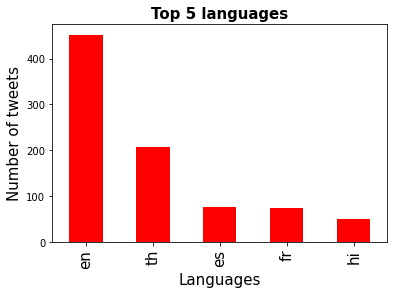

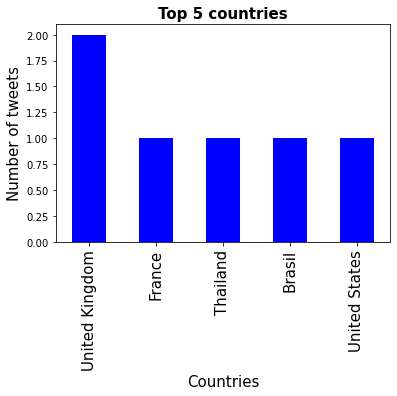

In [15]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

# Hashtag histogram. 

## Please write code that will help you answer the following questions
 1) What is the most used hashtag?
 
 2) What is the most used referenced username?
 
 3) What is the most retweeted tweet?

In [11]:
user = pd.DataFrame(dict(df['user'])).T

In [12]:
# Question 1 : The most used hashtag



In [13]:
# Question 2 : most referenced username

user['screen_name'].value_counts()

Smart5GCitizen     8
CNRC_NRC           7
CofHEQ             7
vijay_rajan_159    6
Penkampar          5
                  ..
Ex_Catho           1
MARIS2911          1
samuraj_dr         1
Son_Of_Sher        1
DVEAProud          1
Name: screen_name, Length: 902, dtype: int64